In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn import tree
from sklearn import linear_model
import warnings
import seaborn as sns
import matplotlib
from keras import regularizers
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings(action='once')

Using TensorFlow backend.


In [12]:
# Dataset import
dataset_path = r'C:\Users\gbian007\Google Drive\Research\UHTC\Database\Model\Dataset1.csv'
raw_dataset = pd.read_csv(dataset_path, na_values="?", comment='\t', sep=",", skipinitialspace=True, encoding='cp1252')
dataset = raw_dataset.copy()
dataset=dataset.drop(columns=['Sintering_Temperature','Sintering_Pressure', 'Sintering_Time', 'Sintering_Method',
                              'Oxidation_Test'])
#,
#                              'Mean_Grain_Size','Relative_Density'
dataset

,ZrB2,HfB2,SiC,Mean_Grain_Size,Relative_Density,Temperature,Time_Temp,Oxide_Thickness
0,100.0,0.0,0.0,10.00,95.80,1400.0,60.000000,291.0
1,100.0,0.0,0.0,5.84,67.60,1300.0,58.333333,98.0
2,100.0,0.0,0.0,5.84,67.60,1300.0,33.333333,69.0
3,100.0,0.0,0.0,5.84,67.60,1300.0,16.666667,57.0
4,100.0,0.0,0.0,NaN,96.50,1200.0,720.000000,175.0
...,...,...,...,...,...,...,...,...
102,0.0,100.0,0.0,12.00,99.20,1400.0,60.000000,248.0
103,0.0,80.0,20.0,6.20,99.90,1400.0,60.000000,12.0
104,0.0,80.0,20.0,2.50,99.51,1400.0,60.000000,20.0
105,0.0,80.0,20.0,2.50,99.00,1400.0,60.000000,25.0


C:\Users\gbian007\Anaconda3\envs\tf\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


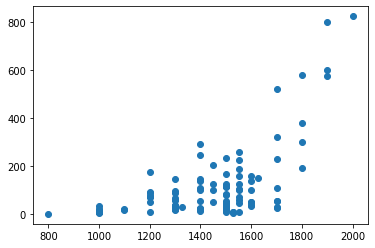

In [13]:
dataset = dataset.dropna(subset=['Oxide_Thickness'])
dataset.isna().sum()
dataset
plt.scatter(dataset['Temperature'], dataset['Oxide_Thickness'])

In [24]:
#Preprocessing
#split train-test
train_dataset = dataset.sample(frac=0.8, random_state=2)
test_dataset = dataset.drop(train_dataset.index)
train_dataset
test_dataset.head()

,ZrB2,HfB2,SiC,Mean_Grain_Size,Relative_Density,Temperature,Time_Temp,Oxide_Thickness
7,95.0,0.0,5.0,3.0,97.4,1200.0,60.0,50.0
15,90.0,0.0,10.0,3.0,100.0,1450.0,1200.0,205.0
20,85.0,0.0,15.0,NaN,NaN,1550.0,240.0,190.0
22,85.0,0.0,15.0,5.5,NaN,1550.0,120.0,60.0
31,80.0,0.0,20.0,NaN,NaN,1550.0,240.0,125.0


In [25]:
# In[4]: Separate Targets from features  Dataset
train_stats = train_dataset.describe()
train_stats.pop('Oxide_Thickness')
train_stats = train_stats.transpose()
train_labels = train_dataset.pop('Oxide_Thickness')
test_labels = test_dataset.pop('Oxide_Thickness')

C:\Users\gbian007\Anaconda3\envs\tf\lib\site-packages\pandas\core\indexes\base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [26]:
# spacy - do their own embedding
# Word embedding - word2vec
# normalization - minmax

# In[5]: Normalization, This could change
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
imptrain = SimpleImputer(missing_values=np.nan, strategy='mean')
imptest = SimpleImputer(missing_values=np.nan, strategy='mean')

Train_scaler = MinMaxScaler()
Test_scaler = MinMaxScaler()

normed_train_data = Train_scaler.fit_transform(train_dataset)
normed_test_data = Test_scaler.fit_transform(test_dataset)

imptrain.fit(normed_train_data)
imptest.fit(normed_test_data)

normed_train_data = imptrain.transform(normed_train_data)
normed_test_data = imptest.transform(normed_test_data)
pd.DataFrame(normed_test_data).head()

,0,1,2,3,4,5,6
0,1.000000,0.0,0.000000,0.250000,0.927978,0.222222,0.036620
1,0.947368,0.0,0.111111,0.250000,1.000000,0.500000,1.000000
2,0.894737,0.0,0.222222,0.341912,0.824758,0.611111,0.188732
3,0.894737,0.0,0.222222,0.562500,0.824758,0.611111,0.087324
4,0.842105,0.0,0.333333,0.341912,0.824758,0.611111,0.188732


C:\Users\gbian007\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_split.py:440: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
C:\Users\gbian007\Anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprec

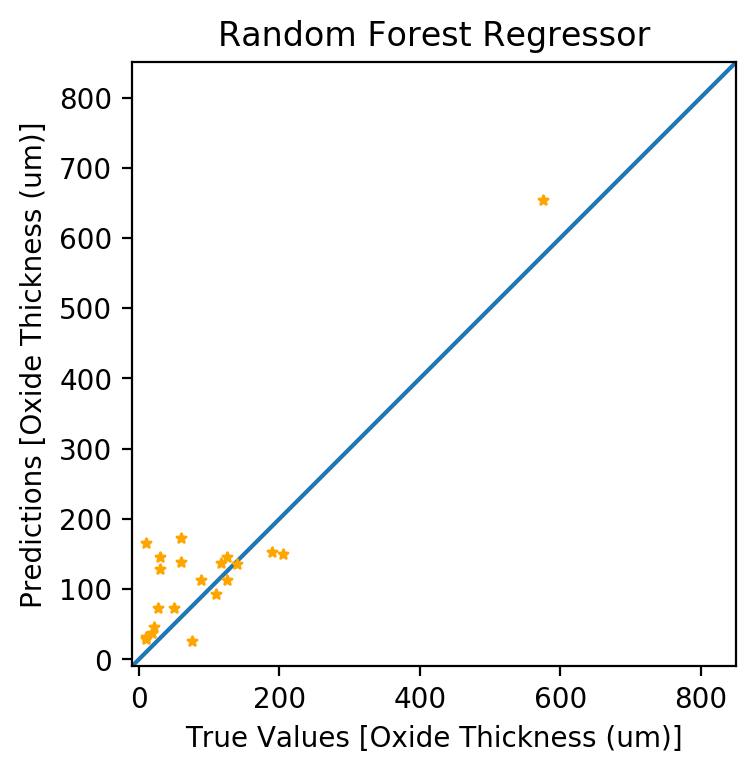

Mean absulote error:  49.04119047619048
Coefficient of Determination:  0.7226494521253704
Parameters: {'criterion': 'mae', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': 50, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100}


In [30]:
# Random Forest regressor with Gridsearch
param_grid = {
    "n_estimators": [50,100,200,300,400],
    "criterion": ['mae'],
    "max_features": ["auto"],
    "max_depth": [None, 2],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2],
    'max_leaf_nodes' : [1,3,50,70,80]
              }   
#train   
rfrreg_opt = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,n_jobs=-1, cv=5)
rfr = rfrreg_opt.fit(normed_train_data, train_labels)
#rfr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=2, min_samples_leaf=2, max_leaf_nodes=None,
#                           bootstrap=True, oob_score=False, n_jobs=1, random_state=2)
#rfr = rfr.fit(normed_train_data, train_labels)
# remove outliers or analyse source
# Cross validation
    
#Testing
rfr_predict = rfr.predict(normed_test_data).flatten()

plt.figure(dpi=200)
plt.scatter(test_labels, rfr_predict, c='orange',s=12, marker='*',zorder=2)
plt.title("Random Forest Regressor")
plt.xlabel('True Values [Oxide Thickness (um)]')
plt.ylabel('Predictions [Oxide Thickness (um)]')
plt.axis('equal')
plt.axis('square')
plt.xlim([-10,850])
plt.ylim(-10,850)
_ = plt.plot([-1000, 1000], [-1000, 1000],zorder=1)
plt.savefig('rfrpred')
plt.show()
print('Mean absulote error: ', mean_absolute_error(test_labels,rfr_predict))
print('Coefficient of Determination: ', r2_score(test_labels,rfr_predict))
print('Parameters:', rfr.best_params_)